In [1]:
import os
import pickle
import numpy 
import pandas as pd
#import cv2
import matplotlib.pyplot as plt
from PIL import Image
from pylab import *
from matplotlib import pyplot
#from numpy import *
from scipy. ndimage import filters
import pandas as pd
import os
from keras.models import Model, Sequential, save_model, load_model
import math
from sklearn.metrics import mean_squared_error

import random
from sklearn.preprocessing import MinMaxScaler
import h5py
import tensorflow as tf


Using TensorFlow backend.


## Procesar Datos

In [2]:
import os 
import pickle
import numpy as np
import random

def preprocess(data_dirs, data_file,name):
    # all_ped_data would be a dictionary with mapping from each ped to their
    # trajectories given by matrix 3 x numPoints with each column
    # in the order x, y, frameId
    # Pedestrians from all datasets are combined
    # Dataset pedestrian indices are stored in dataset_indices
    all_ped_data={}
    dataset_indices=[]
    current_ped = 0
    # For each dataset
    for directory in data_dirs:
        # Define the path to its respective csv file
        #PETS2009-S2L1-mmundo.csv
        #'PETS09-S2L1.txt'
        file_path = os.path.join(directory,name )

        # Cargar datos desde el archivo csv
        # Los datos son una matriz 4x numTrajPoints
        
        
        data = np.genfromtxt(file_path, delimiter=',')
       
        
        # Obtenga el numero de peatones en el conjunto de datos actual
        uni=np.unique(data[:,1])    
        numPeds=np.size(np.unique(data[:,1]))
        print("peatones.............")
        print(numPeds)
       
        # Para cada peaton en el conjunto de datos
        for ped in range(1, numPeds+1):
            #Son los datos de la persona ped
            traj = data[ data[:, 1] == ped]
            #Esta como (x,y,frame_Id)
            traj = traj[:, [2,3,0]]
            
            #Esta como [[x,...],[y,...],[Frame_Id,..]]
            traj=[list(traj[:,0]),list(traj[:,1]),list(traj[:,2])]
            all_ped_data[current_ped + ped] = np.array(traj)

        # Current dataset done
        dataset_indices.append(current_ped+numPeds)
        current_ped += numPeds

    # Los datos completos son una tupla de todos los datos de peatones y los indices de datos del conjunto de datos.
    complete_data = (all_ped_data, dataset_indices)
    # Almacena los datos completos en el archivo pickle
    f = open(data_file, "wb")
    pickle.dump(complete_data, f, protocol=2)
    f.close()
    return complete_data
 

In [3]:
def load_preprocessed(data_file,seq_len,batch_size):
    
    # cargar los datos
    f = open(data_file, "rb")
    raw_data = pickle.load(f)
    f.close()

    # Obtengo los peatones
    all_ped_data =raw_data[0]
 
    #all_ped_data es el vector {[[],[],[]],...,[[],[],[]]} tantos como pedestrian hayan
    # No usamos dataset_indices por ahora
    # dataset_indices = self.raw_data[1]

    # Construimos data con secuencias(o trayectorias) del largo than seq_length_obs
    data = []
    counter = 0

    # para cada peaton en data
    for ped in all_ped_data:
        
        #ped es un numero entero y va de 1 hasta la cantidad total de pedestrian
        # Extract his trajectory
        traj = all_ped_data[ped]
        
           
        # If the length of the trajectory is greater than seq_length (+2 as we need both source and target data)
        #solo se toman las trajectorias de longitud mayor a seq_length+2
        if traj.shape[1] >= (seq_len):
            # TODO: (Improve) Store only the (x,y) coordinates for now
               
            data.append(traj[[0, 1], :].T)
            #print(traj[[0, 1], :].T)
            # Number of batches this datapoint is worth
            #print(traj.shape[1] )
            #print(int(traj.shape[1] / ((seq_length_obs+1))))
            counter += int(traj.shape[1] / ((seq_len)))
        
    # Calculate the number of batches (each of batch_size) in the data
    #counter tiene la cantidad de bloques de 8 pasos
        
    num_batches = int(counter /batch_size)
    #cada bache tiene batch_size conjuntos donde cada conjunto tiene datos de length+2
    return data,num_batches

In [4]:
datasets=[0]
data_dirs = ['../data1/pets']
        
used_data_dirs = [data_dirs[x] for x in datasets]
      
# Directorio de datos donde reside el archivo pickle preprocesado
data_dir = '../data1'

# Defina la ruta del archivo en el que deben almacenarse los datos.
data_file = os.path.join(data_dir, "datos_limpios_pets.cpkl")

name='pixel_pos.csv'
# If the file doesn't exist already or if forcePreProcess is true
#se usa preprocesscsv para los csv y preprocess para el .txt

data=preprocess(used_data_dirs, data_file,name)
datos,numero=load_preprocessed(data_file,12,1)

peatones.............
19


## Otra forma de dividir los datos 

In [5]:
longitud=len(datos)
ind = range(longitud)

lista = []
for i in range(0,longitud,4):
    lista.append(ind[i:i+4])
#print(lista)

combinacion=[(0,1,2,3,4),(0,1,2,4,3),(0,1,3,4,2),(0,2,3,4,1),(1,2,3,4,0)]

def conjunto_datos(combinacion,lista,datos):
    conjunto_entrenamiento = []
    for i in range(len(combinacion)-1):
       # print(i)
        for j in lista[combinacion[i]]:
        #    print(j)
            conjunto_entrenamiento.append(datos[j])
    conjunto_prueba=[]
    for i in lista[combinacion[4]]:
        #print(i)
        conjunto_prueba.append(datos[i])
    
    return conjunto_entrenamiento,conjunto_prueba

In [6]:
train1,test1 = conjunto_datos(combinacion[0],lista,datos)
train2,test2 = conjunto_datos(combinacion[1],lista,datos)
train3,test3 = conjunto_datos(combinacion[2],lista,datos)
train4,test4 = conjunto_datos(combinacion[3],lista,datos)
train5,test5 = conjunto_datos(combinacion[4],lista,datos)

In [7]:
def secuencia(obs_len,pred_len,data):
    tamano = int(len(data))
    
    X,Y,Z= [],[],[]
    for j in range(tamano):
        traj = data[j]
        lon = traj.shape[0]-obs_len-pred_len
        
        for i in range(0,lon+1):
            total = traj[i:(i +obs_len), :]
            X.append(total)
            xx = traj[i:(i + obs_len ), 0]
            yy = traj[i:(i + obs_len ), 1]
            
            #calculamos la x,y con regresion
            t = range(1,len(xx)+1)
            x_mean = np.mean(xx)
            t_mean = np.mean(t)
            t_var = np.var(t)
            #print(t_var)
            xt_cov = np.cov (xx, t)[0][1]
            vx = xt_cov/t_var
            x0 = x_mean-(vx*t_mean)
            
            y_mean = np.mean(yy)
            yt_cov = np.cov (yy, t)[0][1]
            
            vy = yt_cov/t_var
            y0 = y_mean-(vy*t_mean)
            
            sub_Y = []
            sub_Z = []
            for avan in range(1,pred_len+1):
                x_next = x0+vx*(len(xx)+ avan)
                y_next = y0+vy*(len(yy)+ avan)
                #print("aqui imprimooooo................")
                #print(x_next,y_next)
                #print(traj[i+seq_length_obs, :])
                sub_Y.append(traj[i+obs_len+(avan-1),:]-[x_next,y_next])
                sub_Z.append(traj[i+obs_len+(avan-1),:])
            Y.append(sub_Y)
            Z.append(sub_Z)
    return np.array(X), np.array(Y),np.array(Z)

In [8]:
X_train,Y_train,Z_train = secuencia(8,4,train1)

In [10]:
X_test,Y_test,Z_test = secuencia(8,4,test1)

In [ ]:
Y_train[134]

In [ ]:
X,Y,Z = secuencia(8,4,datos)

## Division de los datos en entrenamiento,validacion y prueba 

In [ ]:
#se fija la semilla
import random
random.seed(0)

array_new = arange(len(X))
random.shuffle(array_new)

longitud = len(X)

long1 = int(longitud * 0.7)
long2 = int(longitud*0.20)
long3 = longitud-long1-long2

idx_train = array_new[0:long1]
idx_test = array_new[long1:long1+long2]
idx_val = array_new[long1+long2:]


#Division de datos

X_train = X[idx_train]
Y_train = Y[idx_train]
Z_train = Z[idx_train]

X_test = X[idx_test]
Y_test = Y[idx_test]
Z_test = Z[idx_test]

X_val = X[idx_val]
Y_val = Y[idx_val]
Z_val = Z[idx_val]

In [ ]:
X_test[0]

## Darle el formato de entrada que necesita Keras [samples, pasos de tiempo, caracteristicas ]

In [12]:
# remodelamos la entrada para que sea[muestras, pasos de tiempo, características]
trainX = numpy.reshape(X_train, (X_train.shape[0], X_train.shape[1],X_train.shape[2]))
valX = numpy.reshape(X_test,(X_test.shape[0], X_test.shape[1],X_test.shape[2]))
data_shape = trainX.shape[1:]


## Definimos el modelo 

In [13]:
from keras.models import Sequential
from keras import optimizers
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import RepeatVector
from keras.layers import TimeDistributed
from keras.callbacks import EarlyStopping
from keras import initializers
from datetime import datetime
from keras.utils import plot_model
from keras.layers import Dropout


if 'model' in globals(): del model
model = None

model = Sequential()
model.add(LSTM(13, return_sequences = True, input_shape = data_shape, name='encoder1'))
model.add(Dropout(0.5))
model.add(LSTM(14, name='encoder2'))
model.add(Dropout(0.5))
model.add(RepeatVector(4,name='repit'))
model.add(LSTM(12, return_sequences = True, name='decoder'))
model.add(Dropout(0.5))
model.add(TimeDistributed(Dense(2,name='salida')))


W1031 10:01:12.899676 140074156070656 deprecation_wrapper.py:119] From /home/andrea/anaconda2/lib/python2.7/site-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W1031 10:01:12.922359 140074156070656 deprecation_wrapper.py:119] From /home/andrea/anaconda2/lib/python2.7/site-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W1031 10:01:12.925456 140074156070656 deprecation_wrapper.py:119] From /home/andrea/anaconda2/lib/python2.7/site-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W1031 10:01:13.102516 140074156070656 deprecation_wrapper.py:119] From /home/andrea/anaconda2/lib/python2.7/site-packages/keras/backend/tensorflow_backend.py:133: The name tf.placeholder_with_default is deprecated. Please use tf.compat.v1.placehold

In [15]:
opt = optimizers.RMSprop(lr = 0.01,decay = 1e-2)
#opt = optimizers.Adam(lr = 0.001, beta_1=0.9, beta_2=0.999, amsgrad=False,decay=1e-3)
model.compile( optimizer = opt, loss = 'logcosh' ,metrics = ['mse'])
#
history = model.fit(trainX, Y_train, epochs= 100, batch_size = 12, verbose=2,validation_data=(valX,Y_test))
#plot_model(model, show_shapes =True, to_file='regresion-varios.png')

Train on 4070 samples, validate on 371 samples
Epoch 1/100
 - 5s - loss: 2.6061e-05 - mean_squared_error: 5.2152e-05 - val_loss: 2.4977e-05 - val_mean_squared_error: 4.9962e-05
Epoch 2/100
 - 3s - loss: 1.6993e-05 - mean_squared_error: 3.3991e-05 - val_loss: 2.5940e-05 - val_mean_squared_error: 5.1887e-05
Epoch 3/100
 - 3s - loss: 1.6164e-05 - mean_squared_error: 3.2332e-05 - val_loss: 2.2674e-05 - val_mean_squared_error: 4.5357e-05
Epoch 4/100
 - 3s - loss: 1.5068e-05 - mean_squared_error: 3.0141e-05 - val_loss: 2.0631e-05 - val_mean_squared_error: 4.1270e-05
Epoch 5/100
 - 3s - loss: 1.3867e-05 - mean_squared_error: 2.7739e-05 - val_loss: 1.8777e-05 - val_mean_squared_error: 3.7561e-05
Epoch 6/100
 - 3s - loss: 1.2795e-05 - mean_squared_error: 2.5595e-05 - val_loss: 1.8907e-05 - val_mean_squared_error: 3.7820e-05
Epoch 7/100
 - 3s - loss: 1.2373e-05 - mean_squared_error: 2.4749e-05 - val_loss: 1.7427e-05 - val_mean_squared_error: 3.4862e-05
Epoch 8/100
 - 3s - loss: 1.1675e-05 - mean

Epoch 64/100
 - 5s - loss: 1.0015e-05 - mean_squared_error: 2.0034e-05 - val_loss: 1.5211e-05 - val_mean_squared_error: 3.0426e-05
Epoch 65/100
 - 3s - loss: 1.0070e-05 - mean_squared_error: 2.0143e-05 - val_loss: 1.4562e-05 - val_mean_squared_error: 2.9131e-05
Epoch 66/100
 - 3s - loss: 1.0003e-05 - mean_squared_error: 2.0009e-05 - val_loss: 1.4355e-05 - val_mean_squared_error: 2.8715e-05
Epoch 67/100
 - 3s - loss: 1.0068e-05 - mean_squared_error: 2.0139e-05 - val_loss: 1.4762e-05 - val_mean_squared_error: 2.9531e-05
Epoch 68/100
 - 3s - loss: 1.0092e-05 - mean_squared_error: 2.0187e-05 - val_loss: 1.4567e-05 - val_mean_squared_error: 2.9137e-05
Epoch 69/100
 - 3s - loss: 1.0053e-05 - mean_squared_error: 2.0110e-05 - val_loss: 1.4367e-05 - val_mean_squared_error: 2.8742e-05
Epoch 70/100
 - 3s - loss: 9.9421e-06 - mean_squared_error: 1.9888e-05 - val_loss: 1.4654e-05 - val_mean_squared_error: 2.9314e-05
Epoch 71/100
 - 3s - loss: 9.8894e-06 - mean_squared_error: 1.9783e-05 - val_loss: 

In [17]:
history_dict=history.history
history_dict.keys()

['mean_squared_error', 'loss', 'val_mean_squared_error', 'val_loss']

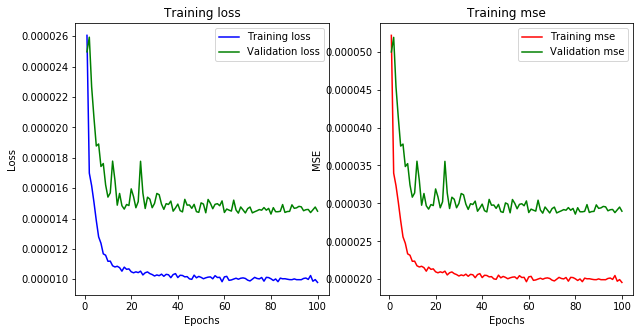

In [19]:
acc = history.history['mean_squared_error']
val_acc = history.history['val_mean_squared_error']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss)+1)

# figure
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'g', label='Validation loss')
plt.title('Training loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.subplot(1,2,2)
plt.plot(epochs, acc, 'r', label='Training mse')
plt.plot(epochs, val_acc, 'g', label='Validation mse')
plt.title('Training mse')
plt.xlabel('Epochs')
plt.ylabel('MSE')
plt.legend()
plt.show()

In [ ]:
#model.save('lstm-regresion-varios0.h5')# se observa 8 pasos

In [ ]:
modelregre = load_model('lstm-regresion-varios0.h5')# la de 8 pasos observados

## Prediccion

In [ ]:
def error_desplazamiento_final(predicted_traj, true_traj):
    tam = len(predicted_traj)
    return np.linalg.norm(predicted_traj[tam-1]-true_traj[tam-1])

In [ ]:
def error_promedio(predicted_traj, true_traj, observed_length):
    
    error = np.zeros(len(true_traj) - observed_length)
    # PARA CADA PUNTO EN LA TRAYECTORIA PREDICHA
    for i in range(observed_length, len(true_traj)):
        # The predicted position
        pred_pos = predicted_traj[i]
        # The true position
        true_pos = true_traj[i]

        # The euclidean distance is the error
        error[i-observed_length] = np.linalg.norm(true_pos - pred_pos)

    # Return the mean error
    return np.mean(error)


In [ ]:
#Funcion para medir el modelo con el conjunto de test
def sample(X_test,Z_test,seq_length_obs,seq_length_pred):
    
    #X,Y_true = secuencia_pred(seq_length_obs,test,seq_length_pred)
    total_error = 0.0
    
    todo = []
    for i in range(len(X_test)):
        traj_obs = X_test[i]
        traj_verdadero = np.concatenate((traj_obs,Z_test[i]),axis=0)
    
        traj_obsr = numpy.reshape(traj_obs, (1,traj_obs.shape[0],traj_obs.shape[1]) )
        predict = modelregre.predict(traj_obsr)
     
        xx = traj_obs[:,0]
        yy = traj_obs[:,1]
        
        t = range(1,len(xx)+1)
        x_mean = np.mean(xx)
        t_mean = np.mean(t)
        t_var = np.var(t)
        xt_cov = np.cov (xx, t)[0][1]
        vx = xt_cov/(t_var)
        x0 = x_mean-(vx*t_mean)
            
        y_mean = np.mean(yy)
        yt_cov = np.cov (yy, t)[0][1]
        
        vy = yt_cov/(t_var)
        y0 = y_mean-(vy*t_mean)
                
        pred=[]
        for avan in range(1,seq_length_pred+1):
            x_next = x0+vx*(len(xx)+avan)
            y_next = y0+vy*(len(yy)+avan)
            
            next_point = [x_next,y_next] + predict[0][avan-1]
            pred.append(next_point)
        pred = np.array(pred)
    
        traj_pred = np.concatenate((traj_obs,pred),axis=0)
            
        diff = traj_verdadero[seq_length_obs:]-traj_pred[seq_length_obs:]
        diff = diff**2
        diff = np.sqrt(np.sum(diff,axis=1))
        todo.append(diff)
        
        total_error += error_promedio(traj_pred , traj_verdadero, seq_length_obs)
    error_modelo = total_error/len(X)
    ade=[t for o in todo for t in o]
    print('--------Error---------')
    print('ADE')
    print(np.mean(ade))
    print('Error promedio')
    print(error_modelo)    

In [ ]:
sample(X_test,Z_test,8,4)

In [ ]:
def sample_en_pixeles(test,obs_len,pred_len):
    
    X,Y_true =secuencia_pred(seq_length_obs,test,seq_length_pred)
    total_error = 0.0
    #len(X)
    for i in range(len(X)):
        traj_obs = X[i]
        traj_pred = X[i]
        #print(traj_obs)
        #print(traj_obs[:,0])
    
        #print(Y_true[i])
        
        for j in range(seq_length_pred):
            traj_obsr = numpy.reshape(traj_obs, (1,traj_obs.shape[0],traj_obs.shape[1]) )
            predict = modelregre.predict(traj_obsr)
             
            xx = traj_obs[:,0]
            yy = traj_obs[:,1]
            
            t = range(1,len(xx)+1)
            x_mean = np.mean(xx)
            t_mean = np.mean(t)
            t_var = np.var(t)
            xt_cov = np.cov (xx, t)[0][1]
            vx = xt_cov/(t_var)
            x0 = x_mean-(vx*t_mean)
            
            y_mean = np.mean(yy)
            yt_cov = np.cov (yy, t)[0][1]
            
            vy = yt_cov/(t_var)
            y0= y_mean-(vy*t_mean)
            
            x_next = x0+vx*(len(xx)+1)
            y_next = y0+vy*(len(yy)+1)
            
            next_point = [x_next,y_next]+predict
          
            traj_obs = np.concatenate((traj_obs[1:len(traj_obs)],next_point),axis=0)
            traj_pred = np.concatenate((traj_pred,next_point),axis=0)
            
       
        traj_pre = []
        traj_tr = []
        for k in range(len(traj_pred)):
            traj_pre.append([768* traj_pred[k,0],576*traj_pred[k,1]])
            traj_tr.append([768* Y_true[i][k,0],576*Y_true[i][k,1]])
        
        traj_pre = np.array(traj_pre)
        traj_tr = np.array(traj_tr)
        
        total_error += error_promedio(traj_pre , traj_tr, seq_length_obs)
    error_modelo = total_error/len(X)
    print(error_modelo)